# Import Basic Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import os
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import optimizers , layers, applications
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML


(785, 572, 3)


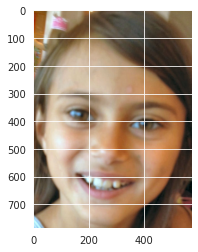

In [3]:
fpath = "/content/drive/MyDrive/AutismDataset/test/Autistic.1.jpg"
img=plt.imread(fpath)
print (img.shape)
plt.imshow(img)

# Loading Train Data

In [4]:
filenames = os.listdir("/content/drive/MyDrive/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
train_df.head()


,filename,category
0,Non_Autistic.1217.jpg,0
1,Non_Autistic.1030.jpg,0
2,Non_Autistic.180.jpg,0
3,Non_Autistic.119.jpg,0
4,Autistic.914.jpg,1


In [6]:
train_df.tail()

,filename,category
2545,Autistic.202.jpg,1
2546,Autistic.433.jpg,1
2547,Autistic.40.jpg,1
2548,Autistic.290.jpg,1
2549,Autistic.539.jpg,1


# Plotting Train Data

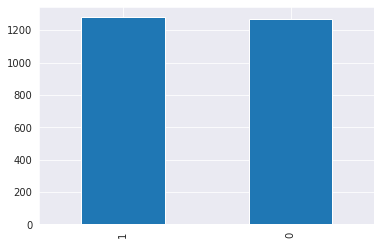

In [7]:
train_df['category'].value_counts().plot.bar()

# Loading Test Data

In [8]:
test_filenames = os.listdir("/content/drive/MyDrive/AutismDataset/test")
categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': categories
})

In [9]:
test_df.head()


,filename,category
0,Autistic.42.jpg,1
1,Autistic.148.jpg,1
2,Autistic.51.jpg,1
3,Autistic.106.jpg,1
4,Autistic.56.jpg,1


In [10]:
test_df.tail()

,filename,category
295,Non_Autistic.53.jpg,0
296,Non_Autistic.73.jpg,0
297,Autistic.91.jpg,1
298,Non_Autistic.47.jpg,0
299,Non_Autistic.144.jpg,0


# Plotting Test Data

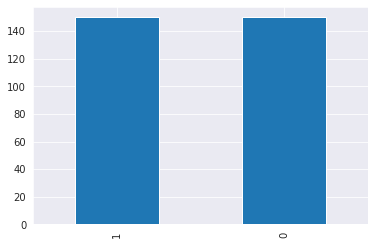

In [11]:
test_df['category'].value_counts().plot.bar()

In [12]:
valid_filenames = os.listdir("/content/drive/MyDrive/AutismDataset/valid")
categories = []
for filename in valid_filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

valid_df = pd.DataFrame({
    'filename': valid_filenames,
    'category': categories
})

In [13]:
valid_df.head()

,filename,category
0,Non_Autistic. (9).jpg,0
1,Autistic. (19).jpg,1
2,Autistic. (7).jpg,1
3,Autistic. (38).jpg,1
4,Non_Autistic. (4).jpg,0


In [14]:
valid_df.tail()

,filename,category
95,Non_Autistic. (30).jpg,0
96,Non_Autistic. (37).jpg,0
97,Non_Autistic. (50).jpg,0
98,Non_Autistic. (49).jpg,0
99,Non_Autistic. (33).jpg,0


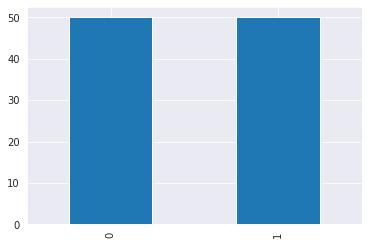

In [15]:
valid_df['category'].value_counts().plot.bar()

# Building VGG16 Model

In [16]:
image_size = 224
input_shape = (image_size, image_size, 3)

#Hyperparameters
epochs = 40
batch_size = 64

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final softmax layer for classification
x = layers.Dense(2, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# Preparing Train Test Data

In [17]:
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use it for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use it for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

# Creating Training Generator For Train Images

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/AutismDataset/train", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2295 validated image filenames belonging to 2 classes.


# Creating Validation Generator For Test Images

In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/AutismDataset/train", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size,image_size),
    batch_size=batch_size
)

Found 255 validated image filenames belonging to 2 classes.


# Fitting The Model 

In [20]:
#Fit Model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/40
35/35 [==============================] - 82s 2s/step - loss: 0.7719 - accuracy: 0.5056 - val_loss: 0.6924 - val_accuracy: 0.4792
Epoch 2/40
35/35 [==============================] - 41s 1s/step - loss: 0.7043 - accuracy: 0.5289 - val_loss: 0.6720 - val_accuracy: 0.6302
Epoch 3/40
35/35 [==============================] - 41s 1s/step - loss: 0.6750 - accuracy: 0.5875 - val_loss: 0.6164 - val_accuracy: 0.7031
Epoch 4/40
35/35 [==============================] - 41s 1s/step - loss: 0.6342 - accuracy: 0.6419 - val_loss: 0.5511 - val_accuracy: 0.7604
Epoch 5/40
35/35 [==============================] - 41s 1s/step - loss: 0.6037 - accuracy: 0.6800 - val_loss: 0.5248 - val_accuracy: 0.8073
Epoch 6/40
35/35 [==============================] - 41s 1s/step - loss: 0.5507 - accuracy: 0.7143 - val_loss: 0.4755 - val_accuracy: 0.7604
Epoch 7/40
35/35 [==============================] - 41s 1s/step - loss: 0.5541 - accuracy: 0.7064 - val_loss: 0.4463 - val_accuracy: 0.7917
Epoch 8/40
35/35 [==

# Accuracy and Loss on Test Data

In [21]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test: accuracy = 0.807292  ;  loss = 0.473739 


# Saving The Model

In [22]:
model.save('vgg16.h5')

# Ploting the Loss And Accuracy

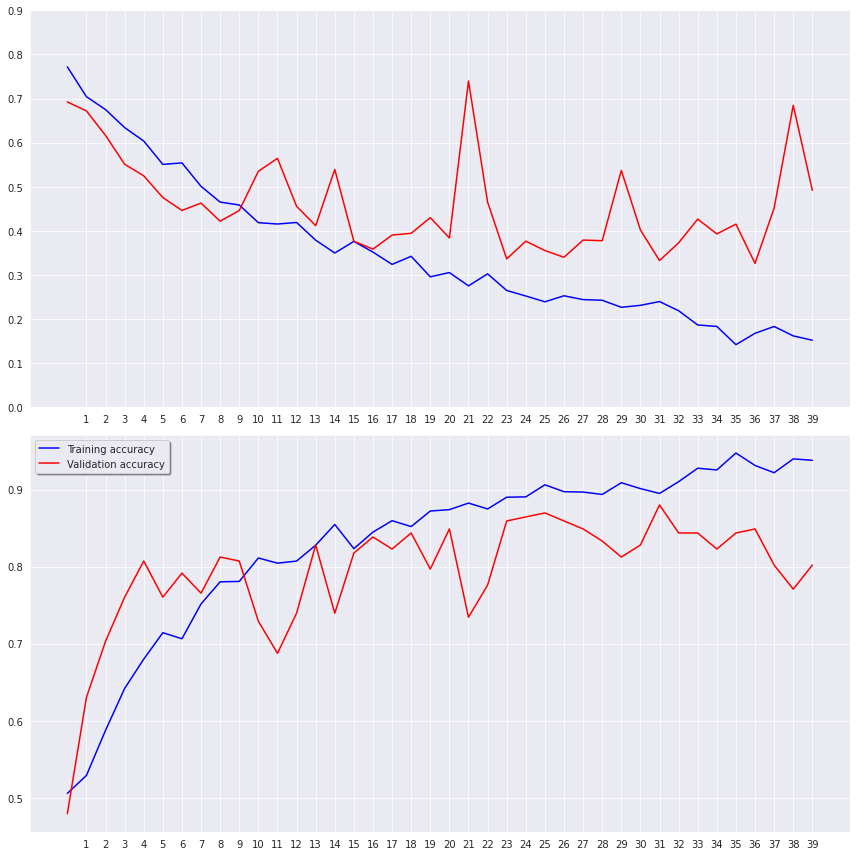

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))


legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Preparing Testing Data

In [24]:
test_filenames = os.listdir("/content/drive/MyDrive/AutismDataset/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Creating Testing Generator

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/AutismDataset/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 300 validated image filenames.


# Predicting on Test Data

In [26]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
predict

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


array([[5.59491031e-02, 9.44050908e-01],
       [1.14772491e-04, 9.99885201e-01],
       [3.75278119e-04, 9.99624729e-01],
       [1.24322530e-03, 9.98756766e-01],
       [3.33013497e-02, 9.66698706e-01],
       [9.74291146e-01, 2.57087909e-02],
       [4.26265651e-05, 9.99957323e-01],
       [2.03174204e-04, 9.99796808e-01],
       [3.04541891e-06, 9.99996901e-01],
       [3.50126997e-03, 9.96498704e-01],
       [6.84484690e-02, 9.31551456e-01],
       [2.25065654e-04, 9.99774992e-01],
       [9.73714411e-01, 2.62856241e-02],
       [2.08040047e-02, 9.79196072e-01],
       [3.88073124e-04, 9.99611914e-01],
       [6.69309346e-04, 9.99330759e-01],
       [2.23032609e-01, 7.76967406e-01],
       [1.64025441e-01, 8.35974514e-01],
       [2.87713017e-03, 9.97122824e-01],
       [1.79178221e-03, 9.98208165e-01],
       [2.21693062e-05, 9.99977827e-01],
       [2.03200543e-04, 9.99796808e-01],
       [5.27243782e-03, 9.94727552e-01],
       [9.45169758e-03, 9.90548313e-01],
       [9.815274

# See The Predicted Result on Test Data

In [28]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df['category']

0      1
1      1
2      1
3      1
4      1
      ..
295    0
296    1
297    1
298    0
299    0
Name: category, Length: 300, dtype: int64

# Creating Testing Images Outside the Dataset to Predict The Result

In [30]:
test_filenames2 = os.listdir("/content/drive/MyDrive/Predictions")
test_df2 = pd.DataFrame({
    'filename': test_filenames2
})
nb_samples = test_df2.shape[0]

# Creating Test Generator  for the Images To Predict

In [31]:
test_gen2 = ImageDataGenerator(rescale=1./255)
test_generator2 = test_gen2.flow_from_dataframe(
    test_df2, 
    "/content/drive/MyDrive/Predictions", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False
)

Found 21 validated image filenames.


# Predictions On The Images

In [34]:
predict2 = model.predict_generator(test_generator2, steps=np.ceil(nb_samples/batch_size))
predict2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


array([[2.3883415e-02, 9.7611654e-01],
       [1.3869470e-04, 9.9986124e-01],
       [6.7050324e-04, 9.9932957e-01],
       [2.4569700e-02, 9.7543031e-01],
       [1.1613180e-02, 9.8838681e-01],
       [3.2105809e-03, 9.9678940e-01],
       [7.8068174e-02, 9.2193186e-01],
       [2.5097805e-04, 9.9974900e-01],
       [1.7849036e-04, 9.9982148e-01],
       [9.2223473e-04, 9.9907780e-01],
       [9.9991024e-01, 8.9761394e-05],
       [9.3694687e-01, 6.3053176e-02],
       [6.4051938e-01, 3.5948068e-01],
       [7.7439159e-01, 2.2560838e-01],
       [9.9971539e-01, 2.8457274e-04],
       [9.9950600e-01, 4.9405219e-04],
       [9.9540859e-01, 4.5913742e-03],
       [9.7382945e-01, 2.6170528e-02],
       [9.9932349e-01, 6.7655463e-04],
       [9.9977249e-01, 2.2751794e-04],
       [8.5833973e-01, 1.4166030e-01]], dtype=float32)

# Printing The Results

In [35]:
test_df2['category'] = np.argmax(predict2, axis=-1)
test_df2['category']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
Name: category, dtype: int64

In [36]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df2['category'] = test_df2['category'].replace(label_map)
test_df2['category']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
Name: category, dtype: object